In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class FaceCompletionDataset(Dataset):
    def __init__(self, image_dir, block_size=(64, 64)):
        self.image_dir = image_dir
        self.block_size = block_size
        self.image_list = os.listdir(image_dir)[:64 * 5]
        
    def __len__(self):
        return len(self.image_list)
    
    def random_block_mask(self, image, block_size=(64, 64)):
        h, w, _ = image.shape
        x = random.randint(0, w - block_size[0])
        y = random.randint(0, h - block_size[1])
        mask = np.zeros((h, w), dtype=np.uint8)
        mask[y:y + block_size[1], x:x + block_size[0]] = 1
        masked_image = image.copy()
        noise = np.random.randint(0, 256, size=(block_size[1], block_size[0], 3), dtype=np.uint8)
        masked_image[y:y + block_size[1], x:x + block_size[0]] = noise
        return masked_image, mask
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_list[idx])
        image = cv2.imread(image_path)

        masked_image, mask = self.random_block_mask(image)

        image = ToTensor()(image)
        #mask = ToTensor()(mask)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) 
        masked_image = ToTensor()(masked_image)

        return image, mask, masked_image

    

image_dir = "preprocessed_images/"

celeba_dataset = FaceCompletionDataset(image_dir)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as spectral_norm_fn
from torch.nn.utils import weight_norm as weight_norm_fn

class Parser(nn.Module):
    def __init__(self, config): # config is not used..
        super(Parser, self).__init__()
        self.input_dim = 3
        self.class_num = 17      # (16 components + backgorund)
        self.cnum = 64

        # 128 * 128 * cnum
        self.conv1_1 = gen_conv(self.input_dim, self.cnum, 7, 1, 1,)
        self.conv1_2 = gen_conv(self.cnum, self.cnum, 3, 2, 1)
        #--self.pool1

        # 64 * 64 * cnum
        self.conv2_1 = gen_conv(self.cnum, self.cnum * 2, 3, 1, 1)
        self.conv2_2 = gen_conv(self.cnum * 2, self.cnum * 2, 3, 2, 1)
        #--self.pool2

        # 32 * 32 * cnum
        self.conv3_1  = gen_conv(self.cnum * 2, self.cnum * 4, 3, 1, 1)
        self.conv3_2 = gen_conv(self.cnum * 4, self.cnum * 4, 3, 1, 1)
        self.conv3_3 = gen_conv(self.cnum * 4, self.cnum * 4, 3, 2, 1)
        #--self.pool3

        # 16 * 16 * cnum
        self.conv4_1 = gen_conv(self.cnum * 4, self.cnum * 8, 3, 1, 1)
        self.conv4_2 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 1, 1)
        self.conv4_3 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 2, 1)
        #--self.pool4

        # 8 * 8 * cnum
        self.conv5_1 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 1, 1)
        self.conv5_2 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 1, 1)
        self.conv5_3 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 2, 1)
        #--self.pool5

        # 4 * 4 * cnum
        self.conv6_1 = gen_conv(self.cnum * 8, 4096, 3, 1, 1)


        #-- self.deconv6
        self.conv7_1  = gen_conv(4096, self.cnum * 8, 5, 1, 2)
        #-- dropout6

        # 8 * 8 * cnum
        #-- self.deconv7
        self.conv8_1 = gen_conv(self.cnum * 8, self.cnum * 8, 5, 1, 2)
        # -- dropout7

        # 16 * 16 * cnum
        #--self.deconv8
        self.conv9_1 = gen_conv(self.cnum * 8, self.cnum * 8, 5, 1, 2)
        # -- dropout8

        # 32 * 32 * cnum
        #-- self.deconv9
        self.conv10_1 = gen_conv(self.cnum * 8, self.cnum * 4, 5, 1, 2)
        # -- dropout9

        # 64 * 64 * cnum
        #--self.deconv10
        self.conv11_1 = gen_conv(self.cnum * 4, self.cnum * 2, 3, 1, 1)
        # -- dropout10

        # 128 * 128 * cnum
        #--self.deconv11
        self.conv12_1 = gen_conv(self.cnum * 2, self.cnum, 3, 1, 1)
        # -- dropout11

        # 128 * 128 * C+1 (FINAL)
        self.h_out = gen_conv(self.cnum, self.class_num, 3, 1, 1)

    def forward(self, x):

        # conv1
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)


        # conv2
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)


        # conv3
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)

        # conv4
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)

        # conv5
        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)

        # conv6
        x = self.conv6_1(x)
        #print(x.shape)

        # conv7
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv7_1(x)
        #print(x.shape)
        x = F.dropout2d(x)

        # conv8
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv8_1(x)
        #print(x.shape)

        # conv9
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv9_1(x)
        #print(x.shape)

        # conv10
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv10_1(x)
        #print(x.shape)

        # conv11
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv11_1(x)
        #print(x.shape)

        # conv12
        #x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv12_1(x)
        #print(x.shape)

        # h_out
        x_out = self.h_out(x)
        #print(x_out.shape)

        return x_out



def gen_conv(input_dim, output_dim, kernel_size=3, stride=1, padding=0, rate=1,
             activation='elu'):
    return Conv2dBlock(input_dim, output_dim, kernel_size, stride,
                       conv_padding=padding, dilation=rate,
                       activation=activation)


def dis_conv(input_dim, output_dim, kernel_size=5, stride=2, padding=0, rate=1,
             activation='lrelu'):
    return Conv2dBlock(input_dim, output_dim, kernel_size, stride,
                       conv_padding=padding, dilation=rate,
                       activation=activation)


class Conv2dBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride, padding=0,
                 conv_padding=0, dilation=1, name='conv', weight_norm='sn', norm='none',
                 activation='relu', pad_type='zero', transpose=False):
        super(Conv2dBlock, self).__init__()
        self.use_bias = True
        # initialize padding
        if pad_type == 'reflect':
            self.pad = nn.ReflectionPad2d(padding)
        elif pad_type == 'replicate':
            self.pad = nn.ReplicationPad2d(padding)
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        elif pad_type == 'none':
            self.pad = None
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        if weight_norm == 'sn':
            self.weight_norm = spectral_norm_fn
        elif weight_norm == 'wn':
            self.weight_norm = weight_norm_fn
        elif weight_norm == 'none':
            self.weight_norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(weight_norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

        # initialize convolution
        if transpose:
            self.conv = nn.ConvTranspose2d(input_dim, output_dim,
                                           kernel_size, stride,
                                           padding=conv_padding,
                                           output_padding=conv_padding,
                                           dilation=dilation,
                                           bias=self.use_bias)
        else:
            self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride,
                                  padding=conv_padding, dilation=dilation,
                                  bias=self.use_bias)

        if self.weight_norm:
            self.conv = self.weight_norm(self.conv)

    def forward(self, x):
        if self.pad:
            x = self.conv(self.pad(x))
        else:
            x = self.conv(x)
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x


In [3]:
from torch.utils.data import DataLoader, random_split

# Assuming your_dataset is an instance of your Dataset class
train_size = int(0.8 * len(celeba_dataset))  # Use 80% of the dataset for training
val_size = len(celeba_dataset) - train_size

train_dataset, val_dataset = random_split(celeba_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
import torch
import torchvision.models as models
vgg16 = models.vgg16(pretrained=False).features

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np
import torch
import torch.nn as nn
import torch.nn as nn
import torchvision.models as models

class Generator(nn.Module):
    def __init__(self, in_channels=3):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            *list(vgg19.features.children())[:18],  # conv1 to pool3 of VGG-19
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(4 * 8 * 8 * 256, 4096),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(4096, 8 * 8 * 256),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, in_channels, kernel_size=5, stride=1, padding=2)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return torch.sigmoid(x2)

## refer from https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/pix2pix/models.py
# However, in the context of image inpainting, we usually have one input, which is the generated/completed image, or the real image for comparison. 
# so i modify the discriminator to accept a single input and process it accordingly. 
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True, stride=2):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=stride, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=False))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512, stride=1),  # Change stride to 1
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img):
        return self.model(img)


In [10]:
#from utils.network_seg_contour import Parser
from argparse import ArgumentParser, Namespace
import torchvision.transforms as transforms
import torchvision.models as models
import torch
import yaml
def get_config(config_file):
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    return config
def get_args():
    parser = ArgumentParser()
    parser.add_argument('--config', type=str, default='config/seg_config.yaml', help="training configuration")
    parser.add_argument('--seed', type=int, default=2023, help='manual seed')

    try:
        args = parser.parse_args()
    except SystemExit:
        args = Namespace(config='config/seg_config.yaml', seed=2023)

    return args

args = get_args()
config = get_config(args.config)
netG = Parser(config)
def load_face_parsing_model(model_path):
    
    netG.load_state_dict(torch.load(model_path), strict=False)
    netG.eval()
    return netG

usage: ipykernel_launcher.py [-h] [--config CONFIG] [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/x1112373/.local/share/jupyter/runtime/kernel-28f3edc2-76db-493f-a900-0091eb7d111a.json


In [12]:
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

generator = Generator()

discriminator_global = Discriminator(in_channels=3)
discriminator_local = Discriminator(in_channels=3)

criterion = nn.BCELoss()
criterion_adv = nn.BCEWithLogitsLoss()
#criterion_context = nn.L1Loss()
criterion_context = nn.MSELoss(reduction='mean')


# optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0002)
# optimizer_discriminator_global = torch.optim.Adam(discriminator_global.parameters(), lr=0.0001)
# optimizer_discriminator_local = torch.optim.Adam(discriminator_local.parameters(), lr=0.0001)
optimizer_generator = torch.optim.RMSprop(generator.parameters(), lr=0.0002)
optimizer_discriminator_global = torch.optim.RMSprop(discriminator_global.parameters(), lr=0.0001)
optimizer_discriminator_local = torch.optim.RMSprop(discriminator_local.parameters(), lr=0.0001)

# Create the schedulers
scheduler_generator = ReduceLROnPlateau(optimizer_generator, mode='min', factor=0.1, patience=5, verbose=True)
scheduler_discriminator_global = ReduceLROnPlateau(optimizer_discriminator_global, mode='min', factor=0.1, patience=5, verbose=True)
scheduler_discriminator_local = ReduceLROnPlateau(optimizer_discriminator_local, mode='min', factor=0.1, patience=5, verbose=True)
 
criterion_perceptual = nn.L1Loss()
face_parsing_model = load_face_parsing_model('pretrained_model/parser_00100000.pt')
face_parsing_model = face_parsing_model.to(device)
face_parsing_model.eval()

Parser(
  (conv1_1): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  )
  (conv1_2): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv2_1): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2_2): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_1): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3_2): Conv2dBlock(
    (pad): Z

In [13]:
def gradient_penalty(discriminator, real_images, fake_images):
    batch_size = real_images.size(0)

    # Create epsilon values for interpolating between real and fake images
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    epsilon = epsilon.expand_as(real_images)

    # Interpolate between real and fake images
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated_images.requires_grad_(True)

    # Compute the discriminator's output on the interpolated images
    interpolated_output = discriminator(interpolated_images)

    # Compute the gradients of the output with respect to the input images
    gradients = torch.autograd.grad(
        outputs=interpolated_output,
        inputs=interpolated_images,
        grad_outputs=torch.ones_like(interpolated_output),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Compute the gradient penalty
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1)**2).mean()

    return penalty


In [14]:
def discriminator_loss(real_output, fake_output):
    return fake_output.mean() - real_output.mean()

def generator_loss(fake_output):
    return -fake_output.mean()

In [15]:
generator = generator.to(device)
discriminator_global = discriminator_global.to(device)
discriminator_local = discriminator_local.to(device)

In [16]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def evaluate_models(G, D_G, D_L, dataloader, discriminator_loss, criterion_context, criterion_perceptual, generator_loss):
    G = G.eval()
    D_G = D_G.eval()
    D_L = D_L.eval()

    total_gen_loss = 0
    total_disc_global_loss = 0
    total_disc_local_loss = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, masks, masked_images) in enumerate(dataloader):
            if i == 0:
                print(i)
            images = images.to(device)
            masks = masks.to(device)
            masked_images = masked_images.to(device) 

            completed_images = G(masked_images)

            real_labels = torch.ones(images.size(0), 1).to(device)
            fake_labels = torch.zeros(images.size(0), 1).to(device)

            local_real_output = D_L(images)
            local_fake_output = D_L(completed_images)

            global_real_output = D_G(images)
            global_fake_output = D_G(completed_images)

            # Expand the real and fake labels to match the output size of the discriminators
            real_labels_expanded = real_labels.view(real_labels.size(0), 1, 1, 1).expand_as(global_real_output).clone()
            fake_labels_expanded = fake_labels.view(fake_labels.size(0), 1, 1, 1).expand_as(global_fake_output).clone()

            real_labels_expanded = real_labels_expanded.to(device)
            fake_labels_expanded = fake_labels_expanded.to(device)

            loss_adv_global = discriminator_loss(global_real_output, real_labels_expanded) + discriminator_loss(global_fake_output, fake_labels_expanded)
            loss_adv_local = discriminator_loss(local_real_output, real_labels_expanded) + discriminator_loss(local_fake_output, fake_labels_expanded)
            loss_adv = loss_adv_global + loss_adv_local 
            loss_g = generator_loss(global_fake_output)

            expanded_masks = masks.expand_as(images)
            loss_context = criterion_context(completed_images * expanded_masks, images * expanded_masks)
            loss_perceptual = criterion_context(face_parsing_model(completed_images), face_parsing_model(images))

            loss_generator = loss_g + loss_context + loss_perceptual

            total_gen_loss += loss_generator.item()
            total_disc_global_loss += loss_adv_global.item()
            total_disc_local_loss += loss_adv_local.item()
            total_samples += images.size(0)

    mean_gen_loss = total_gen_loss / total_samples
    mean_disc_global_loss = total_disc_global_loss / total_samples
    mean_disc_local_loss = total_disc_local_loss / total_samples

    return mean_gen_loss, mean_disc_global_loss, mean_disc_local_loss

def evaluate_model_external(model, dataloader):
    model.eval()
    total_psnr = 0
    total_ssim = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, masks, masked_images) in enumerate(dataloader):
            masked_images = masked_images.to(device) 
            completed_images = model(masked_images)
 
            for i in range(images.size(0)):
                image = images[i].cpu().numpy().transpose(1, 2, 0)
                completed_image = completed_images[i].cpu().numpy().transpose(1, 2, 0)

                total_psnr += psnr(image, completed_image)
                total_ssim += ssim(image, completed_image, multichannel=True, win_size=3, data_range=1)

            total_samples += images.size(0)

    return total_psnr / total_samples, total_ssim / total_samples



In [17]:
import copy
import pandas as pd
import matplotlib.pyplot as plt
def return_image_numpy(images, scale=False):
    if scale:
        completed_images_np = images[0].cpu().detach().numpy()
 
        completed_images_np = ((completed_images_np + 1) * 127.5)
        print(completed_images_np.shape)
        return completed_images_np.transpose(1, 2, 0)
    else:
        return images[0].detach().cpu().numpy().transpose(1, 2, 0)
save_path = './model2/'

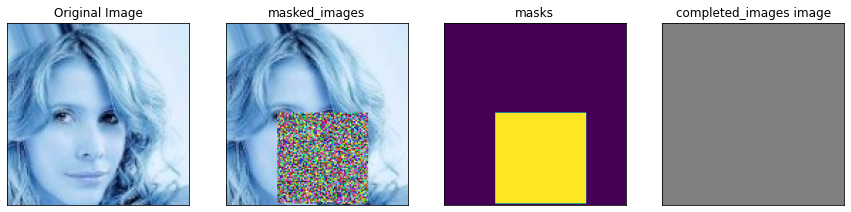

Epoch 00007: reducing learning rate of group 0 to 2.0000e-05.
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00013: reducing learning rate of group 0 to 2.0000e-06.
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 0, Step: 15, Training Losses - Generator: 2.070197343826294, Discriminator Global: 0.8530829548835754, Discriminator Local: -42.42903137207031
0
Epoch: 0, Validation Losses - Generator: 0.12981459, Discriminator Global: 0.05323067, Discriminator Local: -2.77123410
Epoch: 0, Validation PSNR: 4.35225089, SSIM: -0.13002997


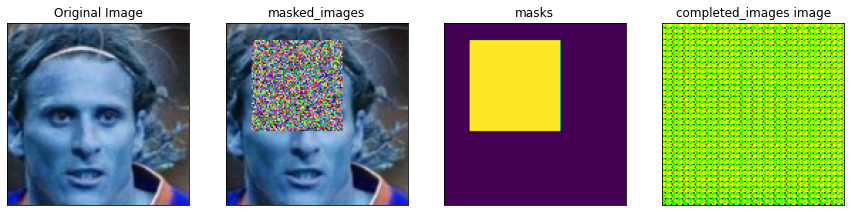

Epoch 00019: reducing learning rate of group 0 to 2.0000e-07.
Epoch 00019: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00025: reducing learning rate of group 0 to 2.0000e-08.
Epoch 00025: reducing learning rate of group 0 to 1.0000e-08.
Epoch 00031: reducing learning rate of group 0 to 2.0000e-09.
Epoch: 1, Step: 15, Training Losses - Generator: 1.9302932024002075, Discriminator Global: 0.8506837487220764, Discriminator Local: -67.87358856201172
0
Epoch: 1, Validation Losses - Generator: 0.12966719, Discriminator Global: 0.05322706, Discriminator Local: -4.32439041
Epoch: 1, Validation PSNR: 4.35225089, SSIM: -0.13002997


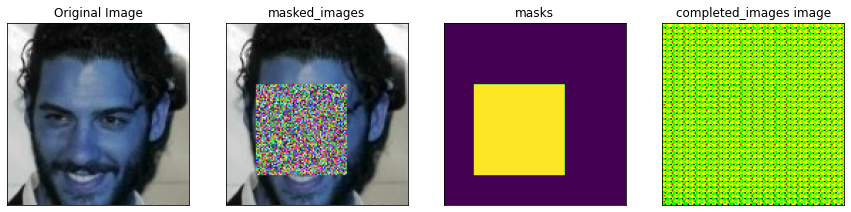

Epoch: 2, Step: 15, Training Losses - Generator: 2.0008139610290527, Discriminator Global: 0.8527979254722595, Discriminator Local: -90.19833374023438
0
Epoch: 2, Validation Losses - Generator: 0.12669555, Discriminator Global: 0.05322691, Discriminator Local: -5.70811296
Epoch: 2, Validation PSNR: 4.35225089, SSIM: -0.13002997


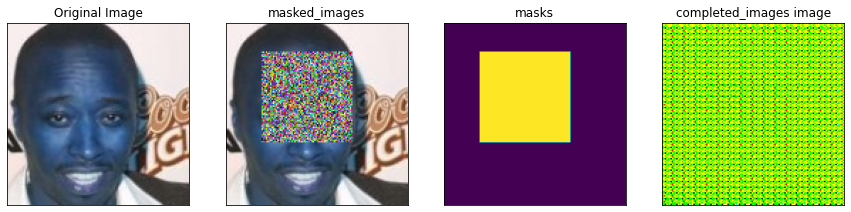

Epoch: 3, Step: 15, Training Losses - Generator: 2.0935559272766113, Discriminator Global: 0.8547919988632202, Discriminator Local: -109.5496826171875
0
Epoch: 3, Validation Losses - Generator: 0.13187745, Discriminator Global: 0.05322669, Discriminator Local: -6.91456008
Epoch: 3, Validation PSNR: 4.35225089, SSIM: -0.13002997


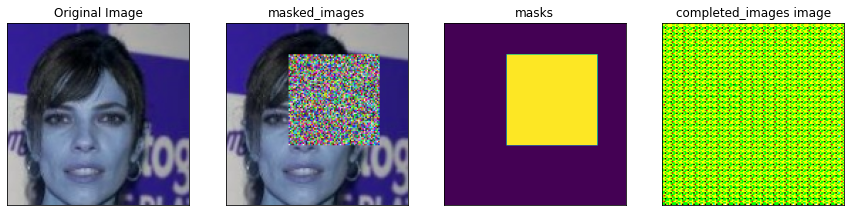

Epoch: 4, Step: 15, Training Losses - Generator: 2.310546398162842, Discriminator Global: 0.8530226945877075, Discriminator Local: -125.47357177734375
0
Epoch: 4, Validation Losses - Generator: 0.12862963, Discriminator Global: 0.05322667, Discriminator Local: -7.89724982
Epoch: 4, Validation PSNR: 4.35225089, SSIM: -0.13002997


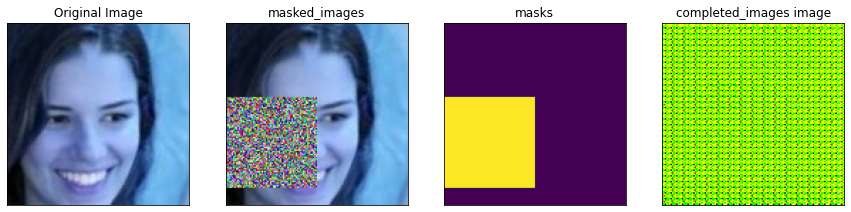

Epoch: 5, Step: 15, Training Losses - Generator: 2.139333963394165, Discriminator Global: 0.8530749678611755, Discriminator Local: -141.06576538085938
0
Epoch: 5, Validation Losses - Generator: 0.12770690, Discriminator Global: 0.05322653, Discriminator Local: -8.87227535
Epoch: 5, Validation PSNR: 4.35225089, SSIM: -0.13002997


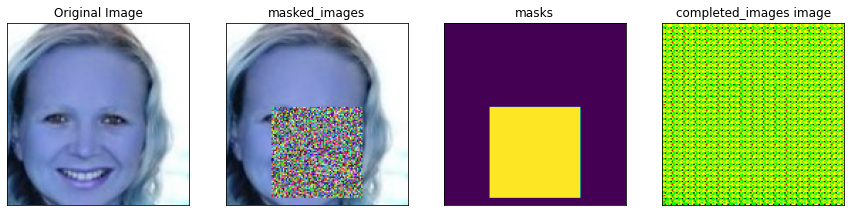

Epoch: 6, Step: 15, Training Losses - Generator: 1.903135061264038, Discriminator Global: 0.8517537713050842, Discriminator Local: -155.4833984375
0
Epoch: 6, Validation Losses - Generator: 0.13098831, Discriminator Global: 0.05322658, Discriminator Local: -9.77066088
Epoch: 6, Validation PSNR: 4.35225089, SSIM: -0.13002997


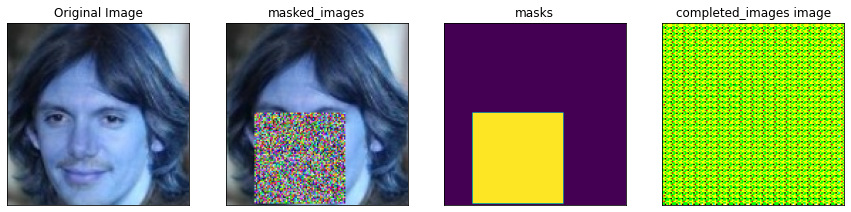

Epoch: 7, Step: 15, Training Losses - Generator: 2.17472505569458, Discriminator Global: 0.8530113697052002, Discriminator Local: -168.82794189453125
0
Epoch: 7, Validation Losses - Generator: 0.12807189, Discriminator Global: 0.05322640, Discriminator Local: -10.59926891
Epoch: 7, Validation PSNR: 4.35225089, SSIM: -0.13002997


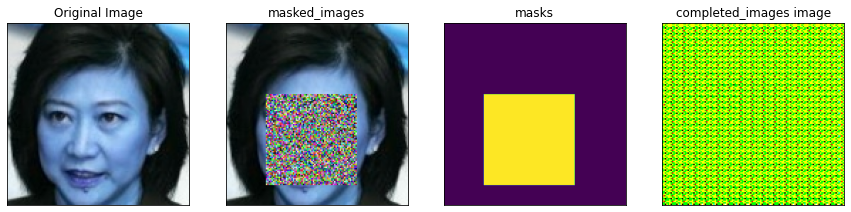

Epoch: 8, Step: 15, Training Losses - Generator: 1.96431303024292, Discriminator Global: 0.8545624613761902, Discriminator Local: -181.58905029296875
0
Epoch: 8, Validation Losses - Generator: 0.12459309, Discriminator Global: 0.05322644, Discriminator Local: -11.39448452
Epoch: 8, Validation PSNR: 4.35225089, SSIM: -0.13002997


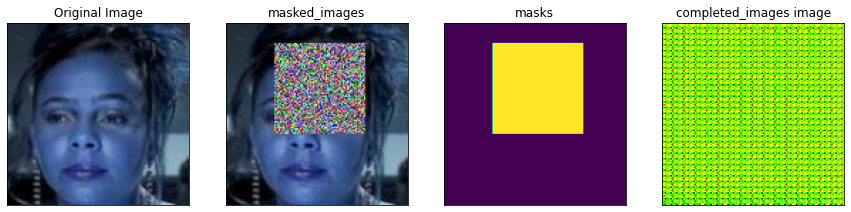

Epoch: 9, Step: 15, Training Losses - Generator: 2.092468738555908, Discriminator Global: 0.8502160906791687, Discriminator Local: -193.9700927734375
0
Epoch: 9, Validation Losses - Generator: 0.13052995, Discriminator Global: 0.05322624, Discriminator Local: -12.16527009
Epoch: 9, Validation PSNR: 4.35225089, SSIM: -0.13002997


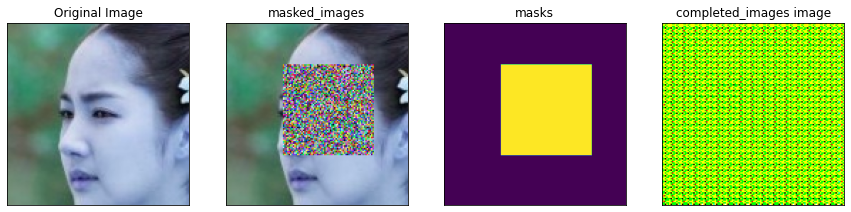

Epoch: 10, Step: 15, Training Losses - Generator: 2.0773446559906006, Discriminator Global: 0.8495460748672485, Discriminator Local: -206.49868774414062
0
Epoch: 10, Validation Losses - Generator: 0.12831189, Discriminator Global: 0.05322606, Discriminator Local: -12.94843459
Epoch: 10, Validation PSNR: 4.35225089, SSIM: -0.13002997


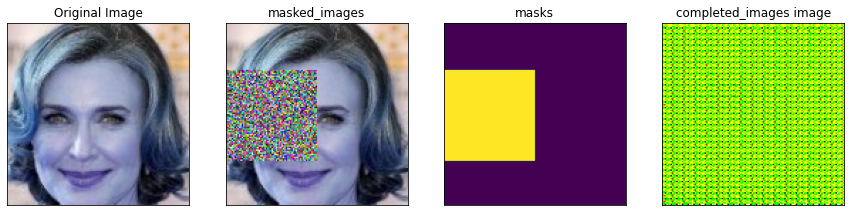

Epoch: 11, Step: 15, Training Losses - Generator: 1.848810076713562, Discriminator Global: 0.8532739877700806, Discriminator Local: -218.44003295898438
0
Epoch: 11, Validation Losses - Generator: 0.13058926, Discriminator Global: 0.05322573, Discriminator Local: -13.69874883
Epoch: 11, Validation PSNR: 4.35225089, SSIM: -0.13002997


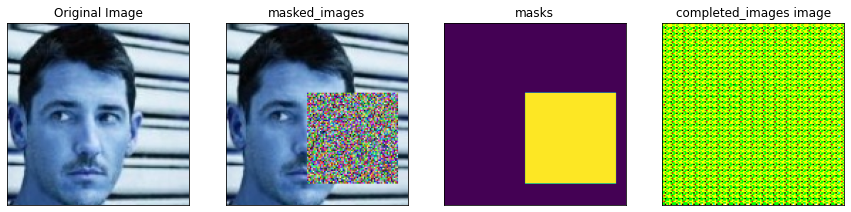

Epoch: 12, Step: 15, Training Losses - Generator: 2.07503080368042, Discriminator Global: 0.8509337306022644, Discriminator Local: -230.0050048828125
0
Epoch: 12, Validation Losses - Generator: 0.12881022, Discriminator Global: 0.05322534, Discriminator Local: -14.42125559
Epoch: 12, Validation PSNR: 4.35225089, SSIM: -0.13002997


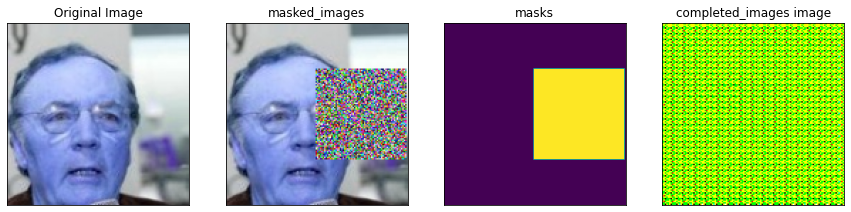

Epoch: 13, Step: 15, Training Losses - Generator: 2.1420061588287354, Discriminator Global: 0.8540711402893066, Discriminator Local: -241.75408935546875
0
Epoch: 13, Validation Losses - Generator: 0.12674244, Discriminator Global: 0.05322525, Discriminator Local: -15.15388060
Epoch: 13, Validation PSNR: 4.35225089, SSIM: -0.13002997


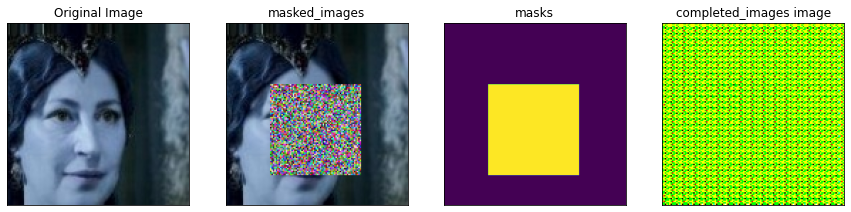

Epoch: 14, Step: 15, Training Losses - Generator: 2.2375755310058594, Discriminator Global: 0.8533951640129089, Discriminator Local: -253.20318603515625
0
Epoch: 14, Validation Losses - Generator: 0.13025482, Discriminator Global: 0.05322500, Discriminator Local: -15.87171221
Epoch: 14, Validation PSNR: 4.35225089, SSIM: -0.13002997


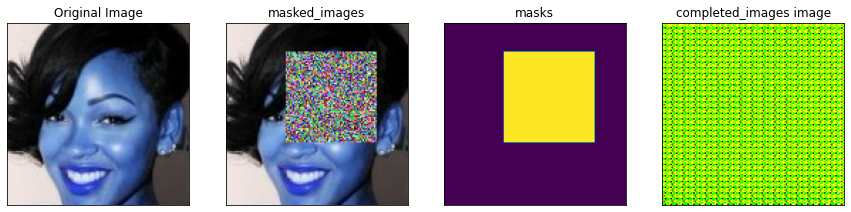

Epoch: 15, Step: 15, Training Losses - Generator: 2.0504651069641113, Discriminator Global: 0.8486062288284302, Discriminator Local: -264.525390625
0
Epoch: 15, Validation Losses - Generator: 0.12489029, Discriminator Global: 0.05322502, Discriminator Local: -16.57003069
Epoch: 15, Validation PSNR: 4.35225089, SSIM: -0.13002997


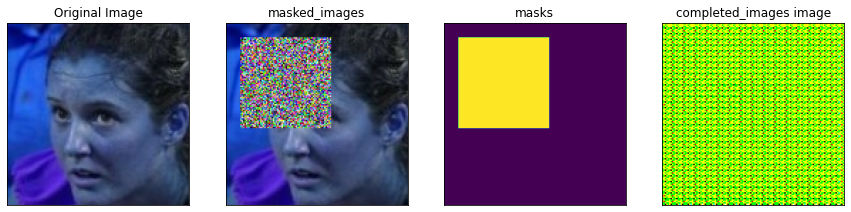

Epoch: 16, Step: 15, Training Losses - Generator: 1.9512132406234741, Discriminator Global: 0.8481811881065369, Discriminator Local: -275.8627014160156
0
Epoch: 16, Validation Losses - Generator: 0.12731538, Discriminator Global: 0.05322503, Discriminator Local: -17.28489161
Epoch: 16, Validation PSNR: 4.35225089, SSIM: -0.13002997


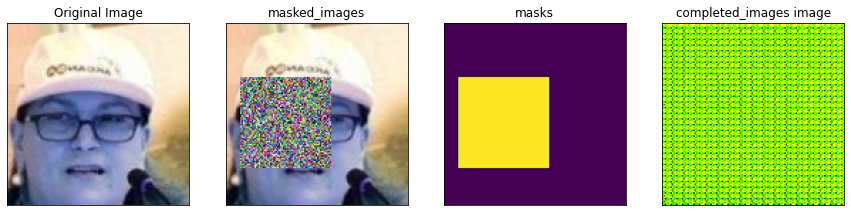

Epoch: 17, Step: 15, Training Losses - Generator: 1.707192301750183, Discriminator Global: 0.8539255857467651, Discriminator Local: -287.00555419921875
0
Epoch: 17, Validation Losses - Generator: 0.12604109, Discriminator Global: 0.05322481, Discriminator Local: -17.98087692
Epoch: 17, Validation PSNR: 4.35225089, SSIM: -0.13002997


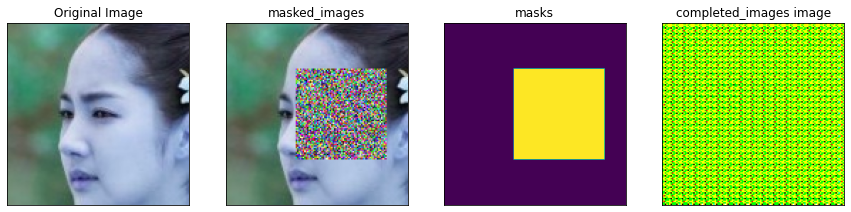

Epoch: 18, Step: 15, Training Losses - Generator: 2.107473373413086, Discriminator Global: 0.8527283668518066, Discriminator Local: -298.1329345703125
0
Epoch: 18, Validation Losses - Generator: 0.12712677, Discriminator Global: 0.05322485, Discriminator Local: -18.67140961
Epoch: 18, Validation PSNR: 4.35225089, SSIM: -0.13002997
Early stopping triggered.


In [18]:
import random
num_epochs = 30
best_loss = float('inf')
patience = 10
lambda_gp = 10  # Gradient penalty weight
result_df = pd.DataFrame(columns= ['epoch', 'step', 'val_gen_loss', 'val_disc_global_loss', 'val_disc_local_loss', 'val_psnr', 'val_ssim' ])
 
for epoch in range(num_epochs):
    for i, (images, masks, masked_images) in enumerate(train_dataloader):
        # Resize the images and masks to a consistent size
        
        images = images.to(device)
        masked_images = masked_images.to(device)
        masks = masks.to(device)
        # Train the generator and discriminators using the images and masks
        # Implement the training algorithm according to the paper
        # 1. Generate completed images using the generator (Completion Network)
        completed_images = generator(masked_images)
 
        # 2. Compute the adversarial loss for the generator using the global and local discriminators
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)
 
        local_real_output = discriminator_local(images)
        local_fake_output = discriminator_local(completed_images)

        global_real_output = discriminator_global(images)
        global_fake_output = discriminator_global(completed_images)

        
        # Expand the real and fake labels to match the output size of the discriminators
        real_labels_expanded = real_labels.view(real_labels.size(0), 1, 1, 1).expand_as(global_real_output).clone()
        fake_labels_expanded = fake_labels.view(fake_labels.size(0), 1, 1, 1).expand_as(global_fake_output).clone()
        
        real_labels_expanded = real_labels_expanded.to(device)
        fake_labels_expanded = fake_labels_expanded.to(device)
        
        # 3. Compute the contextual loss by measuring the L1 distance between the original and completed images
        expanded_masks = masks.expand_as(images)
        loss_adv_global = discriminator_loss(global_real_output, real_labels_expanded) + discriminator_loss(global_fake_output, fake_labels_expanded) + lambda_gp * gp 
        loss_adv_local = discriminator_loss(local_real_output, real_labels_expanded) + discriminator_loss(local_fake_output, fake_labels_expanded) + lambda_gp * gp 
        gp = gradient_penalty(discriminator_global, images, completed_images)
        loss_d = loss_adv_global + loss_adv_local 
        # avoid model collapse
         
        loss_g_global = generator_loss(global_fake_output)
        loss_g_local = generator_loss(local_fake_output)
        loss_g = loss_g_global + loss_g_local
        loss_context = criterion_context(completed_images * expanded_masks, images * expanded_masks)
        loss_perceptual = criterion_context(face_parsing_model(completed_images), face_parsing_model(images))
        loss_generator = loss_g + loss_context + loss_perceptual
        
        optimizer_generator.zero_grad()
        loss_g.backward(retain_graph=True)
        optimizer_generator.step()
        scheduler_generator.step(loss_generator)
        generator.zero_grad()

        # 6. Update the weights of the global and local discriminators using their respective adversarial losses
         
        
        optimizer_discriminator_global.zero_grad()
        optimizer_discriminator_local.zero_grad()
        loss_d.backward()
        optimizer_discriminator_global.step()
        scheduler_discriminator_global.step(loss_adv_global)
        optimizer_discriminator_local.step()
        scheduler_discriminator_local.step(loss_adv_local)
        discriminator_global.zero_grad()
        discriminator_local.zero_grad()
            
        if i % 10000 == 0:
            fig, axs = plt.subplots(1, 4, figsize=(15, 5))
            axs[0].imshow(return_image_numpy(images))
            axs[0].set_title("Original Image")
            axs[1].imshow(return_image_numpy(masked_images))
            axs[1].set_title("masked_images")
            axs[2].imshow(return_image_numpy(masks))
            axs[2].set_title("masks")
            axs[3].imshow(return_image_numpy(completed_images))
            axs[3].set_title("completed_images image")

            for ax in axs:
                ax.set_xticks([])
                ax.set_yticks([])

            plt.show()
    
    # Evaluation
    # Inside your training loop, after each epoch
    print(f"Epoch: {epoch}, Step: {i}, Training Losses - Generator: {loss_generator.item()}, Discriminator Global: {loss_adv_global.item()}, Discriminator Local: {loss_adv_local.item()}")
    val_gen_loss, val_disc_global_loss, val_disc_local_loss = evaluate_models(generator, discriminator_global, discriminator_local, validation_dataloader, discriminator_loss, criterion_context, criterion_perceptual, generator_loss)
    print(f"Epoch: {epoch}, Validation Losses - Generator: {val_gen_loss:.8f}, Discriminator Global: {val_disc_global_loss:.8f}, Discriminator Local: {val_disc_local_loss:.8f}")
    val_psnr, val_ssim = evaluate_model_external(generator, validation_dataloader)
    print(f"Epoch: {epoch}, Validation PSNR: {val_psnr:.8f}, SSIM: {val_ssim:.8f}")
    if epoch == 0:
        result_df = pd.DataFrame([{'epoch': epoch, 'step': i, 'val_gen_loss': val_gen_loss, 'val_disc_global_loss': val_disc_global_loss, 'val_disc_local_loss': val_disc_local_loss, 'val_psnr': val_psnr, 'val_ssim': val_ssim}])
    else:
        aa = pd.DataFrame([{'epoch': epoch, 'step': i, 'val_gen_loss': val_gen_loss, 'val_disc_global_loss': val_disc_global_loss, 'val_disc_local_loss': val_disc_local_loss, 'val_psnr': val_psnr, 'val_ssim': val_ssim}])
        result_df = pd.concat([result_df, aa], axis=0)
        result_df.to_csv('result_df2.csv') 
    # Update the best loss and save the model if necessary
    
    if (val_gen_loss + val_disc_global_loss) < best_loss:
        best_loss = (val_gen_loss + val_disc_global_loss)
        best_generator = copy.deepcopy(generator.state_dict())
        best_discriminator_global = copy.deepcopy(discriminator_global.state_dict())
        best_discriminator_local = copy.deepcopy(discriminator_local.state_dict())
        # Save the best models
        torch.save(best_generator, os.path.join(save_path, 'generator.pth'))
        torch.save(best_discriminator_global, os.path.join(save_path, 'discriminator_global.pth'))
        torch.save(best_discriminator_local, os.path.join(save_path, 'discriminator_local.pth'))

        counter = 0
    else:
        counter += 1

    # Check for early stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break
